# Packages

In [32]:
import os
import json
import time
from pathlib import Path
from datetime import datetime
import ast

import pandas as pd
import geopandas as gpd
import numpy as np

# Loading data

In [33]:
PROJECT_ROOT = Path.cwd().resolve().parent
DATA_DIR = PROJECT_ROOT / "data"
PROCESSED_DIR = DATA_DIR / "processed"
RAW_DIR = DATA_DIR / "raw"

In [49]:
football = pd.read_csv(RAW_DIR / "football_new.csv")

# Exporatory Data Analysis

In [50]:
football.columns

Index(['id', 'index', 'match_id', 'period', 'timestamp', 'second', 'minute',
       'team', 'team_id', 'player', 'player_id', 'position', 'play_pattern',
       'type', 'under_pressure', 'shot_deflected', 'shot_open_goal',
       'shot_type', 'shot_statsbomb_xg', 'shot_freeze_frame', 'location',
       'shot_outcome', 'shot_body_part', 'shot_first_time', 'shot_technique',
       'shot_key_pass_id,', 'shot_one_on_one'],
      dtype='object')

In [64]:
football["shot_type"].value_counts()

shot_type
Open Play    43096
Free Kick     2124
Penalty        486
Corner          13
Name: count, dtype: int64

In [51]:
football.groupby(["shot_type"])["shot_outcome"].count()

shot_type
Corner          13
Free Kick     2124
Open Play    43096
Penalty        486
Name: shot_outcome, dtype: int64

Are we going to look at all the periods? Overtime and also penalty kick?

In [52]:
football["period"].value_counts().sort_index()

period
1    20814
2    24905
Name: count, dtype: int64

I am gonna transform shot outcome column into a 0 and 1 column

In [53]:
football["shot_outcome"].unique().tolist()

['Off T',
 'Goal',
 'Blocked',
 'Saved',
 'Wayward',
 'Post',
 'Saved Off Target',
 'Saved to Post']

I will transform timestamp into a minute ceil column (e.g., 4:32 -> 5th minute)

In [54]:
football["timestamp"].unique()

array(['00:04:21.052', '00:06:27.395', '00:08:16.762', ...,
       '00:45:24.473', '00:45:25.517', '00:47:47.998'],
      shape=(45346,), dtype=object)

I will transform location to a x and y column by making it a list first

In [55]:
football["location"].head()

0    [108.1, 31.2]
1    [110.9, 42.6]
2    [117.9, 29.1]
3    [101.8, 27.6]
4    [109.3, 26.5]
Name: location, dtype: object

<Axes: xlabel='shot_body_part'>

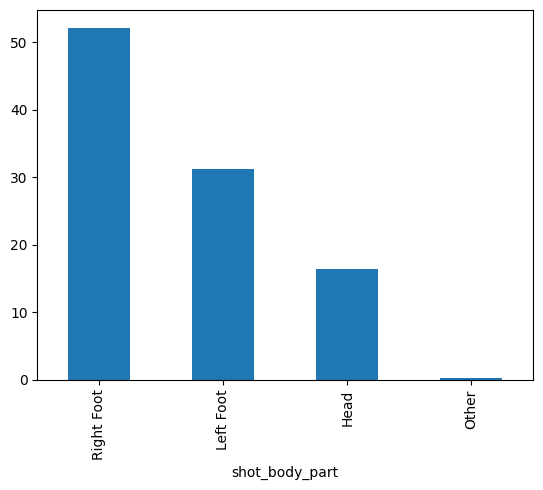

In [63]:
(football["shot_body_part"].value_counts(normalize=True) * 100).plot(kind='bar')

There is no freeze frame data for penalty kicks which makes sense

In [62]:
football[football["shot_freeze_frame"].isna()]["shot_type"].value_counts()

shot_type
Penalty    434
Name: count, dtype: int64

In [58]:
football[(football["period"] != 1) & (football["period"] != 2)].head(2)

,id,index,match_id,period,timestamp,second,minute,team,team_id,player,player_id,position,play_pattern,type,under_pressure,shot_deflected,shot_open_goal,shot_type,shot_statsbomb_xg,shot_freeze_frame,location,shot_outcome,shot_body_part,shot_first_time,shot_technique,"shot_key_pass_id,",shot_one_on_one


Distance from goal

In [59]:
football["shot_outcome"].value_counts()

shot_outcome
Off T               15089
Blocked             11292
Saved               10744
Goal                 4706
Wayward              2704
Post                  870
Saved Off Target      161
Saved to Post         153
Name: count, dtype: int64

# Processing Data

In [65]:
def process_shot_outcome(df):
    outcome_mapping = {
        'Off T': 0,
        'Goal': 1,
        'Blocked': 0,
        'Saved': 0,
        'Wayward': 0,
        'Post': 0,
        'Saved Off Target': 0,
        'Saved to Post': 0
    }

    df['shot_outcome_encoded'] = df['shot_outcome'].map(outcome_mapping)
    return df


###################
# add only foot bcs dont know strong foot yet
###################
def process_shot_body_part(df):
    dummies = pd.get_dummies(df['shot_body_part'], prefix='body_part', drop_first=False, dtype=int)
    dummies.columns = dummies.columns.str.lower().str.replace(" ", "_")

    df = pd.concat([df, dummies], axis=1)
    return df

def process_timestamp(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%H:%M:%S.%f')
    df['time_only'] = df['timestamp'].dt.time
    df['minute'] = df['timestamp'].dt.minute # maybe remove?
    df['second'] = df['timestamp'].dt.second # maybe remove?
    df['minute_ceil'] = df['timestamp'].dt.ceil('min').dt.minute
    return df

def process_location(df):
    df["location"] = df['location'].apply(ast.literal_eval)
    df[["x", "y"]] = pd.DataFrame(df["location"].tolist(), index=df.index)
    return df

def distance_from_goal(df):
    df['distance_from_goal_center'] = np.sqrt((120 - df['x'])**2 + (40 - df['y'])**2) # need to double check
    df['distance_from_goal_left_post'] = np.sqrt((120 - df['x'])**2 + (36 - df['y'])**2)
    df['distance_from_goal_right_post'] = np.sqrt((120 - df['x'])**2 + (44 - df['y'])**2)

    return df

def process_position(df):
    # one hot encoding
    position_dummies = pd.get_dummies(df['position'], prefix='position', drop_first=False, dtype=int)
    position_dummies.columns = position_dummies.columns.str.lower().str.replace(" ", "_")
    df = pd.concat([df, position_dummies], axis=1)
    return df

def process_play_pattern(df):
    # one hot encoding
    play_pattern_dummies = pd.get_dummies(df['play_pattern'], prefix='play_pattern', drop_first=False, dtype=int)
    play_pattern_dummies.columns = play_pattern_dummies.columns.str.lower().str.replace(" ", "_")
    df = pd.concat([df, play_pattern_dummies], axis=1)
    return df

def process_under_pressure(df):
    # Convert True into 1 and NaN into 0
    df['under_pressure'] = df['under_pressure'].fillna(False).astype(int)
    return df

def process_shot_open_goal(df):
    # Convert True into 1 and NaN into 0
    df['shot_open_goal'] = df['shot_open_goal'].fillna(False).astype(int)
    return df

def process_shot_technique(df):
    # one hot encoding
    technique_dummies = pd.get_dummies(df['shot_technique'], prefix='shot_technique', drop_first=False, dtype=int)
    technique_dummies.columns = technique_dummies.columns.str.lower().str.replace(" ", "_")
    df = pd.concat([df, technique_dummies], axis=1)
    return df

In [67]:
football = process_shot_outcome(football)
football = process_timestamp(football)
# football = process_location(football)
football = distance_from_goal(football)
football = process_shot_body_part(football)
football = process_shot_technique(football)

# show all columns
pd.set_option('display.max_columns', None)

football

,id,index,match_id,period,timestamp,second,minute,team,team_id,player,player_id,position,play_pattern,type,under_pressure,shot_deflected,shot_open_goal,shot_type,shot_statsbomb_xg,shot_freeze_frame,location,shot_outcome,shot_body_part,shot_first_time,shot_technique,"shot_key_pass_id,",shot_one_on_one,shot_outcome_encoded,time_only,minute_ceil,x,y,distance_from_goal_center,distance_from_goal_left_post,distance_from_goal_right_post,body_part_head,body_part_left_foot,body_part_other,body_part_right_foot,body_part_head,body_part_left_foot,body_part_other,body_part_right_foot,shot_technique_backheel,shot_technique_diving_header,shot_technique_half_volley,shot_technique_lob,shot_technique_normal,shot_technique_overhead_kick,shot_technique_volley
0,ba46e9d6-e828-4599-952c-39c1f7d22659,263,3890561,1,1900-01-01 00:04:21.052,21,4,Hoffenheim,175,Tarik Elyounoussi,26832.0,Left Wing Back,Regular Play,Shot,NaN,NaN,NaN,Open Play,0.087901,"[{'location': [115.7, 50.0], 'player': {'id': ...","[108.1, 31.2]",Off T,Left Foot,True,Half Volley,NaN,NaN,0,00:04:21.052000,5,108.1,31.2,14.800338,12.831602,17.477128,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0
1,85d67225-30fb-47c8-b478-cf568941a164,353,3890561,1,1900-01-01 00:06:27.395,27,6,Schalke 04,181,Klaas-Jan Huntelaar,8060.0,Center Forward,From Throw In,Shot,NaN,NaN,NaN,Open Play,0.160274,"[{'location': [98.4, 33.1], 'player': {'id': 8...","[110.9, 42.6]",Goal,Right Foot,True,Volley,NaN,NaN,1,00:06:27.395000,7,110.9,42.6,9.464143,11.241441,9.207063,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1
2,adac17d3-5e67-4e8c-b482-4bae2f36e06e,410,3890561,1,1900-01-01 00:08:16.762,16,8,Hoffenheim,175,Kevin Volland,8215.0,Left Attacking Midfield,From Throw In,Shot,True,NaN,NaN,Open Play,0.016036,"[{'location': [101.9, 52.4], 'player': {'id': ...","[117.9, 29.1]",Blocked,Left Foot,True,Half Volley,NaN,NaN,0,00:08:16.762000,9,117.9,29.1,11.100450,7.212489,15.047259,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0
3,abffd193-62bc-4c8d-8636-1e3f0f0ebbe5,624,3890561,1,1900-01-01 00:13:55.721,55,13,Schalke 04,181,Jean-Eric Maxim Choupo-Moting,3499.0,Left Midfield,From Counter,Shot,NaN,NaN,NaN,Open Play,0.527759,"[{'location': [93.1, 35.3], 'player': {'id': 9...","[101.8, 27.6]",Goal,Left Foot,NaN,Normal,NaN,NaN,1,00:13:55.721000,14,101.8,27.6,22.022716,20.044949,24.498980,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0
4,d9cea903-f92a-40e1-a393-1a849d83f157,749,3890561,1,1900-01-01 00:17:16.953,16,17,Schalke 04,181,Klaas-Jan Huntelaar,8060.0,Center Forward,Regular Play,Shot,NaN,NaN,NaN,Open Play,0.074020,"[{'location': [88.4, 69.5], 'player': {'id': 3...","[109.3, 26.5]",Saved,Right Foot,NaN,Normal,NaN,NaN,0,00:17:16.953000,18,109.3,26.5,17.226143,14.308739,20.511948,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45714,2d60277a-da24-4e8a-aa97-42f2cb0830fa,3758,3878540,2,1900-01-01 00:44:37.645,37,44,Lazio,236,Danilo Cataldi,7107.0,Center Defensive Midfield,Regular Play,Shot,True,NaN,NaN,Open Play,0.030999,"[{'location': [102.4, 37.8], 'player': {'id': ...","[98.6, 40.4]",Blocked,Left Foot,NaN,Normal,NaN,NaN,0,00:44:37.645000,45,98.6,40.4,21.403738,21.847654,21.700691,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0
45715,7d4e50ce-7ecd-44a1-b242-d1001d05417a,3785,3878540,2,1900-01-01 00:45:22.885,22,45,Bologna,240,Franco Brienza,45591.0,Center Attacking Midfield,From Free Kick,Shot,NaN,NaN,NaN,Open Play,0.042634,"[{'location': [115.9, 42.2], 'player': {'id': ...","[103.0, 51.3]",Blocked,Left Foot,True,Normal,NaN,NaN,0,00:45:22.885000,46,103.0,51.3,20.412986,22.871161,18.501081,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0
45716,fa4f5417-a44e-4d14-b4f5-05925d778a07,3789,3878540,2,1900-01-01 00:45:24.473,24,45,Bologna,240,Franco Brienza,45591.0,Center Attacking Midfield,From Free Kick,Shot,NaN,NaN,NaN,Open Play,0.038101,"[{'location': [116.3, 42.0], 'player': {'id': ...","[103.8, 51.4]",Wayward,Right Foot,True,Half Volley,NaN,NaN,0,00: